In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import re
from tensorflow.keras import layers,models
import sklearn.metrics as metrics
from numpy.fft import fft, fft2, rfft, rfft2, fftfreq, fftshift
import scipy.signal as signal
from tensorflow_addons.metrics import F1Score
import tensorflow_addons as tfa
import scipy

%matplotlib notebook

In [3]:
data_root = Path('.')/'data'

In [4]:
target_folder = data_root/'2020'
student_pattern = "s\d{7}"

files = {}
for (dirpath, dirnames, filenames) in os.walk(target_folder):
  s_match = re.search(student_pattern, dirpath)
  # if regex matches, and files exist
  if s_match and filenames:
    s = s_match.group()
    # print(f"adding files for {s} (in {dirpath})")
    dir = Path(dirpath)
    try: files[s]
    except KeyError: files[s] = []
    # only accept .csv files
    files[s].extend([dir/f for f in filenames if f[-4:] == '.csv'])

print("File count:")
{k: len(v) for (k, v) in files.items()}

File count:


{'s1621503': 84,
 's1704037': 80,
 's1736273': 84,
 's1735229': 84,
 's1701688': 84,
 's1737472': 2,
 's1758009': 78,
 's1710228': 84,
 's1660711': 84,
 's1655560': 78,
 's1768094': 165,
 's1770036': 78,
 's2017768': 11,
 's1721039': 76,
 's1746788': 84,
 's1758499': 84,
 's1709221': 71,
 's1711507': 233,
 's1642301': 84,
 's1764751': 92,
 's1616573': 94}

In [5]:
ACTIVITY_CODE_TO_TFCODE_MAPPING = {
  0:   0,   # "Sitting",
  4:   1,   # "Sitting bent forward",
  5:   2,   # "Sitting bent backward",
  1:   3,   # "Walking at normal speed",
  100: 4,   # "Standing",
  2:   5,   # "Lying down on back",
  7:   6,   # "Lying down left",
  6:   7,   # "Lying down right",
  8:   8,   # "Lying down on stomach",
  9:   9,   # "Movement",
  11:  10,  # "Running",
  12:  11,  # "Climbing stairs",
  13:  12,  # "Descending stairs",
  31:  13,  # "Desk work"
}

ACTIVITY_TFCODE_TO_CODE_MAPPING = {
  0:  0,   # "Sitting",
  1:  4,   # "Sitting bent forward",
  2:  5,   # "Sitting bent backward",
  3:  1,   # "Walking at normal speed",
  4:  100, # "Standing",
  5:  2,   # "Lying down on back",
  6:  7,   # "Lying down left",
  7:  6,   # "Lying down right",
  8:  8,   # "Lying down on stomach",
  9:  9,   # "Movement",
  10: 11,  # "Running",
  11: 12,  # "Climbing stairs",
  12: 13,  # "Descending stairs",
  13: 31,  # "Desk work"
}

LABELS = {
    0:  "Sitting",
    1:  "Sitting bent forward",
    2:  "Sitting bent backward",
    3:  "Walking at normal speed",
    4:  "Standing",
    5:  "Lying down on back",
    6:  "Lying down left",
    7:  "Lying down right",
    8:  "Lying down on stomach",
    9:  "Movement",
    10: "Running",
    11: "Climbing stairs",
    12: "Descending stairs",
    13: "Desk work"
}

CLASSES = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 2,
    5: 3,
    6: 3,
    7: 3,
    8: 3,
    9: 4,
    10: 5, 
    11: 6,
    12: 7,
    13: 0
}

CLASS_LABELS = {
    0: "Sitting",
    1: "Walking",
    2: "Standing",
    3: "Lying",
    4: "Movement",
    5: "Running",
    6: "Climbing Stairs",
    7: "Descending stairs"
}

CLASS_LABELS_NOMO = {
    0: "Sitting",
    1: "Walking",
    2: "Standing",
    3: "Lying",
    5: "Running",
    6: "Climbing Stairs",
    7: "Descending stairs"
}

In [6]:
from dataclasses import dataclass

header_size = 5

@dataclass
class Header:
  sensor_pos: str
  sensor_side: str
  act_type: str
  act_code: np.ndarray
  subject_id: str
  # https://stackoverflow.com/a/54863771/9184658
  def __post_init__(self):
    self.act_code = ACTIVITY_CODE_TO_TFCODE_MAPPING[int(self.act_code)]


@dataclass
class Activity:
  header: Header
  df: pd.DataFrame

def read_custom_file(filename):
  with open(filename) as f:
    head = [next(f).rstrip().split('# ')[1] for x in range(header_size)]
    header = Header(*[s.split(': ')[1] for s in head])
    # for l in head:
    #   print(l)
    # print(header)

    df = pd.read_csv(filename, header=header_size)
    return Activity(header, df)

In [7]:
def plot_respeck_fig(df):
  fig = plt.figure(figsize=(10, 8))
  plt.plot(df['accel_x'], label="accel_x")
  plt.plot(df['accel_y'], label="accel_y")
  plt.plot(df['accel_z'], label="accel_z")
  plt.legend()
  return plt

In [8]:
act = read_custom_file(files["s1621503"][0])
act

Activity(header=Header(sensor_pos='Wrist', sensor_side='Right', act_type='Lying down right', act_code=7, subject_id='s1621503'), df=         timestamp  seq   accel_x   accel_y   accel_z
0    1601826499860    0  0.080566 -0.230530 -0.979065
1    1601826499938    1  0.081055 -0.230042 -0.978577
2    1601826500017    2  0.084961 -0.233215 -0.978333
3    1601826500096    3  0.083740 -0.231750 -0.979797
4    1601826500175    4  0.084473 -0.232483 -0.981750
..             ...  ...       ...       ...       ...
411  1601826532226  411  0.060547 -0.211487 -0.983704
412  1601826532305  412  0.060547 -0.207825 -0.989075
413  1601826532383  413  0.060303 -0.204407 -0.987366
414  1601826532462  414  0.061279 -0.208313 -0.986145
415  1601826532541  415  0.061523 -0.207092 -0.984924

[416 rows x 5 columns])

In [9]:
keys = ["accel_x", "accel_y", "accel_z"]

In [10]:
window_size = 100
step_size = 50

In [11]:
sensor_pos = 'Chest'
sensor_side = 'Right'

In [12]:
# split students into train and test set

students = list(files.keys())

students.remove('s1737472')
    
split = int(len(students) * 0.8)
train_students = students[:split]
test_students = students[split:]


In [13]:
test_students

['s1711507', 's1642301', 's1764751', 's1616573']

In [14]:
def get_activities(files, students, window_size, sensor_pos, sensor_side):
    student_files = [files[student] for student in students]
    
    activities = [read_custom_file(filename) for student in student_files for filename in student]
    activities = [activity for activity in activities if not activity.df.empty and len(activity.df.index) >= window_size and activity.header.sensor_pos == sensor_pos and activity.header.sensor_side == sensor_side]
    
    return activities

In [15]:
train_activities = get_activities(files, train_students, window_size, sensor_pos, sensor_side)

test_activities = get_activities(files, test_students, window_size, sensor_pos, sensor_side)


In [16]:
# X = data
# Y = labels

def create_data_arrays(activities):
    data = np.array([activity.df.get(keys).values for activity in activities], dtype=object)
    labels = np.array([activity.header.act_code for activity in activities])
    
    return data, labels

In [17]:
train_data_raw, train_labels_raw = create_data_arrays(train_activities)

test_data_raw, test_labels_raw = create_data_arrays(test_activities)


In [47]:
# the Euclidean norm (vector magnitude) of the three raw signals minus 1, referred to as ENMO; 
def enmo(data):
    arr_enmo = []
    
    for arr in data:
        norm = np.sum(np.abs(arr)**2,axis=-1)**(1./2) - 1.0
        norm[norm < 0] = 0
        arr_enmo.append(np.c_[arr, norm])
    
    return np.array(arr_enmo)

In [43]:
# https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

def smooth(data, box_pts):
    box = np.ones(box_pts)/box_pts
    data_smooth = []
    for arr in data:
        data_smooth.append(scipy.ndimage.convolve1d(arr, box, mode='reflect', axis=0))
    return np.array(data_smooth)

In [44]:
def standardize(X):
    x = (X - np.mean(X,axis=0))/np.std(X,axis=0)
    return x

def standardize_array(data_raw):
    data = np.zeros(data_raw.shape, dtype=object)
    
    for i in range(len(data)):
        data[i] = (standardize(data_raw[i]))
        
    return data

In [51]:
# standardize input data

train_data = enmo(train_data_raw) #smooth(train_data_raw, 10) # standardize_array(train_data_raw)

test_data = enmo(test_data_raw) #smooth(test_data_raw, 10) # standardize_array(test_data_raw)

In [52]:
def window_data(data_array, label_array, window_size, step_size, hamming = False):
    windowed_data = []
    windowed_labels = []
    
    for i in range(len(label_array)):
        arr = data_array[i]
        label = label_array[i]
        start_i = 0
        end_i = start_i + window_size

        while end_i < arr.shape[0]:
            if hamming:
                window = arr[start_i:end_i] * np.hamming(window_size)[:,None]
            else:
                window = arr[start_i:end_i]
            if label != 9:
                windowed_data.append(window)
                windowed_labels.append(label)
            start_i = start_i + step_size
            end_i = start_i + window_size
        
    return np.array(windowed_data), np.array(windowed_labels)

In [53]:
train_data_win, train_label_win = window_data(train_data, train_labels_raw, window_size, step_size, True)

test_data_win, test_label_win = window_data(test_data, test_labels_raw, window_size, step_size, True)

print(train_data_win.shape)
print(train_label_win.shape)

print(test_data_win.shape)
print(test_label_win.shape)

(3330, 100, 4)
(3330,)
(373, 100, 4)
(373,)


In [54]:
def fftransform(windowed_data):
    
    fft_data = []
    
    filter_freq = 12.5*0.01
    
    overlap = 10
    window_size = 25
    
    for i in range(len(windowed_data)):
        window_spec = []
        
        arr = windowed_data[i]

        start_i = 0
        end_i = start_i + window_size

        while end_i <= arr.shape[0]:
            window = arr[start_i:end_i] * np.hamming(window_size)[:,None]
            
            mag = np.abs(fft(window, axis = 0)) 
            
            mag[mag < 0.1] = 0
            
            window_spec.append(mag)
            
            start_i = end_i - overlap
            end_i = start_i + window_size
        fft_data.append(window_spec)
    
    
    freqs = fftfreq(len(mag[0]), d=1.0/12.5)
    return np.array(fft_data)

In [55]:
def make_spectrogram(windowed_data):
    f, t, Sxx = signal.spectrogram(windowed_data[:,:,0], fs=12.5, axis=1)
    return f, t, Sxx

In [56]:
train_fft = fftransform(train_data_win)
test_fft = fftransform(test_data_win)

#f, t, Sxx = make_spectrogram(train_data_win)
#plt.pcolormesh(t, fftshift(f), fftshift(Sxx, axes=0), shading='gouraud')

test_fft.shape

(373, 6, 25, 4)

In [57]:
# one hot encoding of output labels

train_labels = np.array(pd.get_dummies(train_label_win))
test_labels = np.array(pd.get_dummies(test_label_win))

In [58]:
train_labels_grouped = np.array([CLASSES[i] for i in train_label_win])
test_labels_grouped = np.array([CLASSES[i] for i in test_label_win])

In [59]:
train_labels_grouped = np.array(pd.get_dummies(train_labels_grouped))
test_labels_grouped = np.array(pd.get_dummies(test_labels_grouped))

In [60]:
f1_score = F1Score(num_classes=7, average='macro')

In [61]:
#https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r)
    
    #print(predictions)
    
    return accuracy

In [62]:
#https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
# fit and evaluate a model
def evaluate_model_batch_norm(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r)
    
    #print(predictions)
    
    return accuracy

In [63]:
def evaluate_model_batch_norm_2d(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_bins, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainX.shape[3], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_bins, n_features)))
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score

In [64]:
def evaluate_model_group_norm_2d(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_bins, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainX.shape[3], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_bins, n_features)))
    model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(tfa.layers.GroupNormalization(groups=4, axis=3))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', f1_score])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy, f1score = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    #save_model(model, r)
    
    #print(predictions)
    
    return accuracy, f1score

In [65]:
# fit and evaluate a model
def evaluate_model_2(trainX, trainy, testX, testy, r):
    verbose, epochs, batch_size = 1, 40, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = models.Sequential()
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    predictions = model.predict(testX)
    
    save_model(model, r)
    
    #print(predictions)
    
    return accuracy

In [66]:
# summarize scores
def summarize_results(scores, name):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('%s: %.3f%% (+/-%.3f)' % (name, m, s))


In [68]:
# run an experiment
def run_experiment(trainX, trainy, testX, testy, repeats=1):
    # repeat experiment
    scores = list()
    models = list()
    for r in range(repeats):
        score = evaluate_model_batch_norm(trainX, trainy, testX, testy, r)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
        models.append
    # summarize results
    summarize_results(scores)
    
def run_experiment_2d(trainX, trainy, testX, testy, repeats=1):
    # repeat experiment
    scores = list()
    f1scores = list()
    models = list()
    for r in range(repeats):
        score, f1score = evaluate_model_batch_norm_2d(trainX, trainy, testX, testy, r)
        score = score * 100.0
        f1score = f1score * 100.0 
        print('>#%d: Acc %.3f F1 %.3f' % (r+1, score, f1score))
        scores.append(score)
        f1scores.append(f1score)
        models.append
    # summarize results
    summarize_results(scores, 'Accuracy')
    summarize_results(f1scores, 'F1 Score')
    
def save_model(model, n):
    # Convert the model.
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    model_filename = 'models/cnn_model_fft_filtered01_sf_nomove_enmo_' + str(n) + '_' + sensor_pos + '_' + sensor_side + '.tflite' 
    # Save the model.
    with open(model_filename, 'wb') as f:
        f.write(tflite_model)

In [69]:
run_experiment(train_data_win, train_labels, test_data_win, test_labels, 5)

>#1: 44.166
>#2: 42.308
>#3: 45.018
>#4: 41.946
>#5: 41.585
[44.166237115859985, 42.307692766189575, 45.018067955970764, 41.94630980491638, 41.58492386341095]
Accuracy: 43.005% (+/-1.343)


In [90]:
run_experiment(train_data_win, train_labels_grouped, test_data_win, test_labels_grouped, 5)

Train on 3533 samples
Epoch 1/40
3533/3533 [==============================] - 2s 438us/sample - loss: 0.9905 - accuracy: 0.6623
Epoch 2/40
3533/3533 [==============================] - 2s 474us/sample - loss: 0.6949 - accuracy: 0.7484
Epoch 3/40
3533/3533 [==============================] - 1s 317us/sample - loss: 0.6423 - accuracy: 0.7552
Epoch 4/40
3533/3533 [==============================] - 1s 300us/sample - loss: 0.5581 - accuracy: 0.7840
Epoch 5/40
3533/3533 [==============================] - 1s 255us/sample - loss: 0.4943 - accuracy: 0.8157
Epoch 6/40
3533/3533 [==============================] - 1s 255us/sample - loss: 0.4767 - accuracy: 0.8081
Epoch 7/40
3533/3533 [==============================] - 1s 233us/sample - loss: 0.4272 - accuracy: 0.8378
Epoch 8/40
3533/3533 [==============================] - 1s 231us/sample - loss: 0.3812 - accuracy: 0.8576
Epoch 9/40
3533/3533 [==============================] - 1s 231us/sample - loss: 0.3654 - accuracy: 0.8576
Epoch 10/40
3533/3533 [=

3533/3533 [==============================] - 2s 469us/sample - loss: 0.1078 - accuracy: 0.9587
Epoch 34/40
3533/3533 [==============================] - 2s 452us/sample - loss: 0.0987 - accuracy: 0.9652
Epoch 35/40
3533/3533 [==============================] - 2s 444us/sample - loss: 0.1090 - accuracy: 0.9632
Epoch 36/40
3533/3533 [==============================] - 2s 428us/sample - loss: 0.1029 - accuracy: 0.9629
Epoch 37/40
3533/3533 [==============================] - 2s 463us/sample - loss: 0.0901 - accuracy: 0.9663
Epoch 38/40
3533/3533 [==============================] - 1s 370us/sample - loss: 0.1117 - accuracy: 0.9624
Epoch 39/40
3533/3533 [==============================] - 1s 362us/sample - loss: 0.1127 - accuracy: 0.9677
Epoch 40/40
3533/3533 [==============================] - 1s 364us/sample - loss: 0.0802 - accuracy: 0.9728
>#4: 57.213
Train on 3533 samples
Epoch 1/40
3533/3533 [==============================] - 2s 461us/sample - loss: 0.9449 - accuracy: 0.6691
Epoch 2/40
3533/

In [69]:
run_experiment_2d(train_fft, train_labels_grouped, test_fft, test_labels_grouped, 5)

Epoch 1/40
105/105 [==============================] - 2s 15ms/step - loss: 0.7184 - accuracy: 0.7279 - f1_score: 0.6006
Epoch 2/40
105/105 [==============================] - 2s 15ms/step - loss: 0.5402 - accuracy: 0.7808 - f1_score: 0.6773
Epoch 3/40
105/105 [==============================] - 1s 12ms/step - loss: 0.5073 - accuracy: 0.7988 - f1_score: 0.7041
Epoch 4/40
105/105 [==============================] - 1s 11ms/step - loss: 0.4676 - accuracy: 0.8177 - f1_score: 0.7393
Epoch 5/40
105/105 [==============================] - 1s 11ms/step - loss: 0.4327 - accuracy: 0.8249 - f1_score: 0.7542
Epoch 6/40
105/105 [==============================] - 1s 11ms/step - loss: 0.4084 - accuracy: 0.8351 - f1_score: 0.7744
Epoch 7/40
105/105 [==============================] - 1s 11ms/step - loss: 0.3838 - accuracy: 0.8571 - f1_score: 0.8038
Epoch 8/40
105/105 [==============================] - 1s 11ms/step - loss: 0.3574 - accuracy: 0.8607 - f1_score: 0.8078
Epoch 9/40
105/105 [====================

105/105 [==============================] - 1s 8ms/step - loss: 0.2171 - accuracy: 0.9222 - f1_score: 0.9017
Epoch 23/40
105/105 [==============================] - 1s 8ms/step - loss: 0.2243 - accuracy: 0.9144 - f1_score: 0.8814
Epoch 24/40
105/105 [==============================] - 1s 8ms/step - loss: 0.2433 - accuracy: 0.9111 - f1_score: 0.8882
Epoch 25/40
105/105 [==============================] - 1s 8ms/step - loss: 0.1834 - accuracy: 0.9246 - f1_score: 0.8995
Epoch 26/40
105/105 [==============================] - 1s 8ms/step - loss: 0.1384 - accuracy: 0.9486 - f1_score: 0.9387
Epoch 27/40
105/105 [==============================] - 1s 8ms/step - loss: 0.1239 - accuracy: 0.9511 - f1_score: 0.9463
Epoch 28/40
105/105 [==============================] - 1s 8ms/step - loss: 0.1521 - accuracy: 0.9402 - f1_score: 0.9311
Epoch 29/40
105/105 [==============================] - 1s 8ms/step - loss: 0.1523 - accuracy: 0.9405 - f1_score: 0.9344
Epoch 30/40
105/105 [==============================]

INFO:tensorflow:Assets written to: /tmp/tmpw4rw6p3r/assets


>#2: Acc 77.212 F1 66.813
Epoch 1/40
105/105 [==============================] - 1s 11ms/step - loss: 0.7465 - accuracy: 0.7144 - f1_score: 0.5857
Epoch 2/40
105/105 [==============================] - 1s 12ms/step - loss: 0.5396 - accuracy: 0.7871 - f1_score: 0.6891
Epoch 3/40
105/105 [==============================] - 1s 12ms/step - loss: 0.4925 - accuracy: 0.8057 - f1_score: 0.7222
Epoch 4/40
105/105 [==============================] - 1s 13ms/step - loss: 0.4563 - accuracy: 0.8168 - f1_score: 0.7390
Epoch 5/40
105/105 [==============================] - 1s 13ms/step - loss: 0.4423 - accuracy: 0.8258 - f1_score: 0.7582
Epoch 6/40
105/105 [==============================] - 1s 13ms/step - loss: 0.4189 - accuracy: 0.8348 - f1_score: 0.7684
Epoch 7/40
105/105 [==============================] - 1s 13ms/step - loss: 0.4067 - accuracy: 0.8387 - f1_score: 0.7820
Epoch 8/40
105/105 [==============================] - 1s 13ms/step - loss: 0.3850 - accuracy: 0.8453 - f1_score: 0.7906
Epoch 9/40
105

INFO:tensorflow:Assets written to: /tmp/tmpalt1x8o_/assets


>#3: Acc 75.603 F1 62.511
Epoch 1/40
105/105 [==============================] - 1s 5ms/step - loss: 0.7321 - accuracy: 0.7246 - f1_score: 0.6012
Epoch 2/40
105/105 [==============================] - 1s 5ms/step - loss: 0.5381 - accuracy: 0.7862 - f1_score: 0.6917
Epoch 3/40
105/105 [==============================] - 1s 6ms/step - loss: 0.4796 - accuracy: 0.8042 - f1_score: 0.7260
Epoch 4/40
105/105 [==============================] - 1s 8ms/step - loss: 0.4439 - accuracy: 0.8198 - f1_score: 0.7406
Epoch 5/40
105/105 [==============================] - 1s 8ms/step - loss: 0.3796 - accuracy: 0.8508 - f1_score: 0.7944
Epoch 6/40
105/105 [==============================] - 1s 8ms/step - loss: 0.3902 - accuracy: 0.8429 - f1_score: 0.7853
Epoch 7/40
105/105 [==============================] - 1s 8ms/step - loss: 0.3641 - accuracy: 0.8592 - f1_score: 0.8133
Epoch 8/40
105/105 [==============================] - 1s 8ms/step - loss: 0.3481 - accuracy: 0.8685 - f1_score: 0.8207
Epoch 9/40
105/105 [==

INFO:tensorflow:Assets written to: /tmp/tmprc8t3_c_/assets


>#4: Acc 82.306 F1 73.397
Epoch 1/40
105/105 [==============================] - 1s 7ms/step - loss: 0.7617 - accuracy: 0.7189 - f1_score: 0.6054
Epoch 2/40
105/105 [==============================] - 1s 7ms/step - loss: 0.5900 - accuracy: 0.7715 - f1_score: 0.6732
Epoch 3/40
105/105 [==============================] - 1s 7ms/step - loss: 0.4948 - accuracy: 0.8060 - f1_score: 0.7270
Epoch 4/40
105/105 [==============================] - 1s 7ms/step - loss: 0.4763 - accuracy: 0.8075 - f1_score: 0.7349
Epoch 5/40
105/105 [==============================] - 1s 7ms/step - loss: 0.4369 - accuracy: 0.8258 - f1_score: 0.7642
Epoch 6/40
105/105 [==============================] - 1s 7ms/step - loss: 0.4001 - accuracy: 0.8390 - f1_score: 0.7859
Epoch 7/40
105/105 [==============================] - 1s 7ms/step - loss: 0.3972 - accuracy: 0.8384 - f1_score: 0.7830
Epoch 8/40
105/105 [==============================] - 1s 7ms/step - loss: 0.3772 - accuracy: 0.8471 - f1_score: 0.7952
Epoch 9/40
105/105 [==

INFO:tensorflow:Assets written to: /tmp/tmp76z_fw6s/assets


>#5: Acc 80.697 F1 66.949
[79.89276051521301, 77.21179723739624, 75.60321688652039, 82.30562806129456, 80.69705367088318]
Accuracy: 79.142% (+/-2.418)
[68.57190132141113, 66.81316494941711, 62.510502338409424, 73.39696288108826, 66.94934964179993]
F1 Score: 67.648% (+/-3.507)


In [46]:
def get_predictions_from_saved_model(model_filename, testX):
    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_filename)
    interpreter.allocate_tensors()

    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    predictions = []
    for x in testX:
        interpreter.set_tensor(input_details[0]['index'], [x])
    
        interpreter.invoke()
    
        predictions.append(interpreter.get_tensor(output_details[0]['index']))
    
    return np.array(predictions)

In [47]:
tf_filename = 'cnn_model_batch_norm_2_Chest_Right'
tf_filepath = 'models/' + tf_filename + '.tflite'
predictions = get_predictions_from_saved_model(tf_filepath, np.array(test_data_win, dtype=np.float32))

In [48]:
predictions.shape

(373, 1, 14)

In [49]:
np.std(predictions, axis=2)

array([[0.2509204 ],
       [0.25321442],
       [0.25294918],
       [0.25334716],
       [0.25368884],
       [0.2530645 ],
       [0.25257516],
       [0.23145398],
       [0.22383572],
       [0.22971779],
       [0.21628752],
       [0.21386947],
       [0.21288727],
       [0.16031227],
       [0.24284112],
       [0.24714987],
       [0.24703102],
       [0.2479528 ],
       [0.25031486],
       [0.25085717],
       [0.25461453],
       [0.25257763],
       [0.2524718 ],
       [0.25086853],
       [0.2471104 ],
       [0.24661854],
       [0.24391611],
       [0.24343324],
       [0.23224725],
       [0.23316872],
       [0.23470043],
       [0.22357379],
       [0.19179925],
       [0.19238187],
       [0.1954357 ],
       [0.19410254],
       [0.19390796],
       [0.19492595],
       [0.25701326],
       [0.25663352],
       [0.25620285],
       [0.25651982],
       [0.2563374 ],
       [0.25584957],
       [0.2564485 ],
       [0.2564305 ],
       [0.25660253],
       [0.256

In [50]:
pred_labels = np.argmax(predictions, axis=2)

<IPython.core.display.Javascript object>


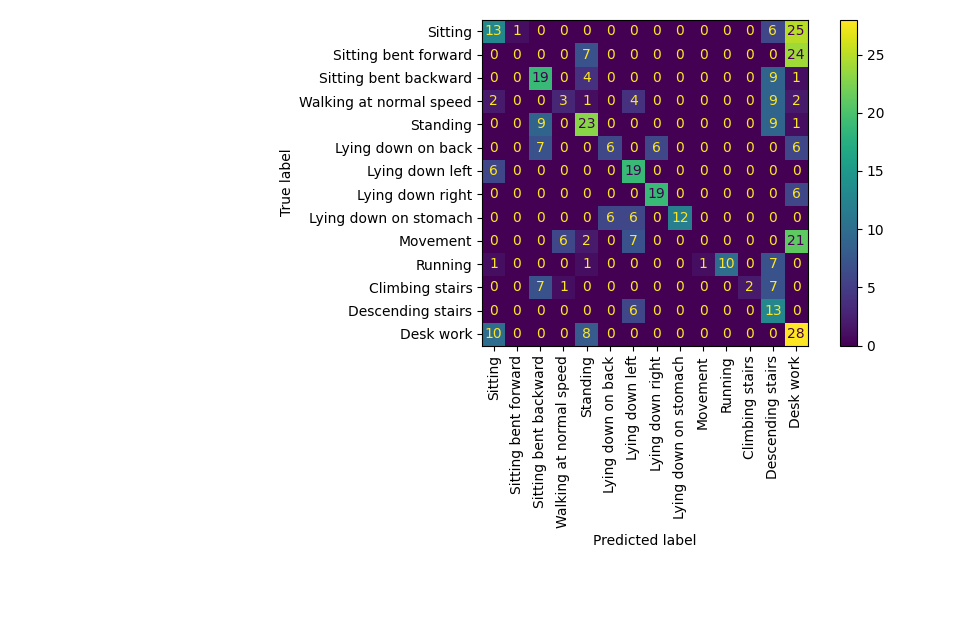

In [97]:
cm = metrics.confusion_matrix(np.argmax(test_labels, axis=1), pred_labels) # change to test_labels for all activities 

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS.values())
disp.plot(xticks_rotation='vertical')
plt.tight_layout()
plt.show()
plt.savefig(tf_filename + '.png')

In [46]:
standardisation = [31.55737817287445, 33.42026770114899, 30.02980649471283, 33.23397934436798, 30.29060959815979]
epochs_10 = [42.473918199539185, 39.71683979034424, 29.88077402114868, 39.30700421333313, 46.050670742988586]
epochs_20 = [41.840535402297974, 33.196720480918884, 37.89120614528656, 45.90163826942444, 38.226526975631714]
epochs_30 = [40.387481451034546, 45.566317439079285, 36.810728907585144, 43.3308482170105, 36.62444055080414]
epochs_40 = [39.82861340045929, 32.82414376735687, 42.324888706207275, 46.460506319999695, 43.66616904735565]

epochs_40_full_data = [38.40991258621216, 36.80949807167053, 47.70263433456421, 42.307692766189575, 39.029428362846375]
epochs_40_full_data_batch_normalisation = [44.166237115859985, 42.307692766189575, 45.018067955970764, 41.94630980491638, 41.58492386341095]
epochs_40_full_data_batch_normalisation_grouped = [62.98399567604065, 59.21528339385986, 63.810014724731445, 62.13216185569763, 55.60144782066345]


window_50_epochs_40 = [37.38650977611542, 37.87289261817932, 40.4020756483078, 38.197147846221924, 37.02983260154724]
window_150_epochs_40 = [46.45358920097351, 40.49912393093109, 42.3380047082901, 37.25919425487518, 44.78984177112579]

window_100_steps_50 = [63.56968283653259, 66.74816608428955, 62.59168982505798, 59.90220308303833, 58.92420411109924]
window_100_steps_25 = [63.499999046325684, 66.12499952316284, 63.24999928474426, 67.37499833106995, 62.87500262260437]

kernel_6 = [64.79217410087585, 46.454766392707825, 67.48166084289551, 68.9486563205719, 67.97065734863281]
kernel_9 = [57.21271634101868, 67.48166084289551, 65.28117656707764, 53.05623412132263, 46.21026813983917]

fft_grouped = [70.9046483039856, 69.68215107917786, 72.86063432693481, 72.86063432693481, 71.3936448097229]
fft_filtering_sqr = [68.21516156196594, 66.25916957855225, 67.48166084289551, 66.9926643371582, 67.48166084289551]
fft_filtering_01 = [70.66014409065247, 73.10513257980347, 73.10513257980347, 70.17114758491516, 71.8826413154602]

movement_removed = [76.40750408172607, 81.23324513435364, 78.28418016433716, 77.47989296913147, 75.33512115478516]

fft_ungrouped = [34.2298299074173, 35.4523241519928, 36.43031716346741, 37.408313155174255, 32.51833617687225]


layers_3_10 = [35.99105775356293, 33.79284739494324, 41.09537899494171, 41.46795868873596, 42.17585623264313]
layers_3_30 = [43.96423101425171, 35.58122217655182, 42.324888706207275, 43.8152015209198, 32.97317326068878]
layers_3_filters_32 = [39.493292570114136, 40.83457589149475, 31.929954886436462, 33.830103278160095, 39.67958390712738]
layers_3_filters_128 = [30.588674545288086, 46.16244435310364, 32.22801685333252, 30.81222176551819, 42.36214458942413]


<IPython.core.display.Javascript object>


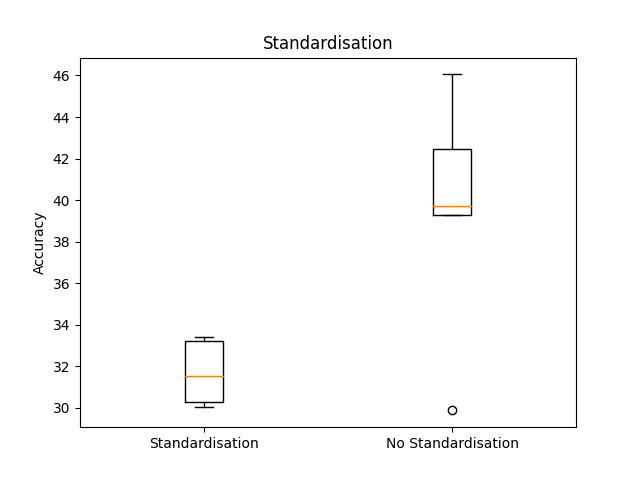

In [159]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Standardisation')
ax1.boxplot([standardisation, epochs_10], labels=['Standardisation', 'No Standardisation'])
plt.show()

<IPython.core.display.Javascript object>


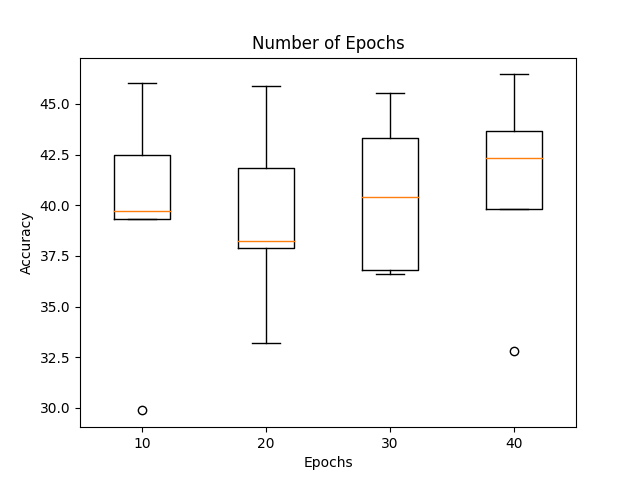

In [160]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Number of Epochs')
ax1.boxplot([epochs_10, epochs_20, epochs_30, epochs_40], labels=['10', '20', '30', '40'])
plt.show()

<IPython.core.display.Javascript object>


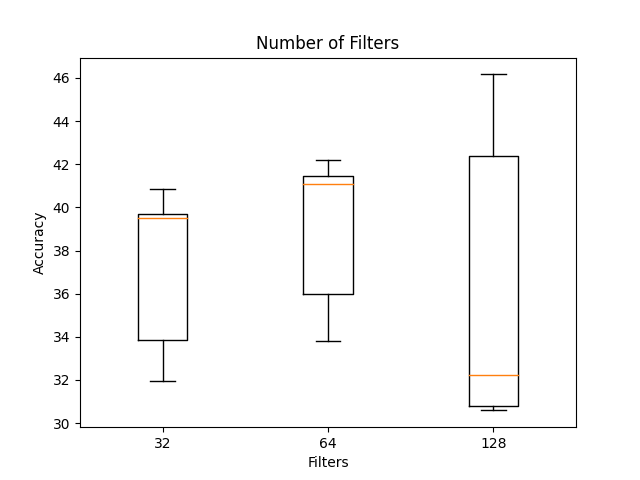

In [161]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Filters')
ax1.set_ylabel('Accuracy')
ax1.set_title('Number of Filters')
ax1.boxplot([layers_3_filters_32, layers_3_10, layers_3_filters_128], labels=['32', '64', '128'])
plt.show()

<IPython.core.display.Javascript object>


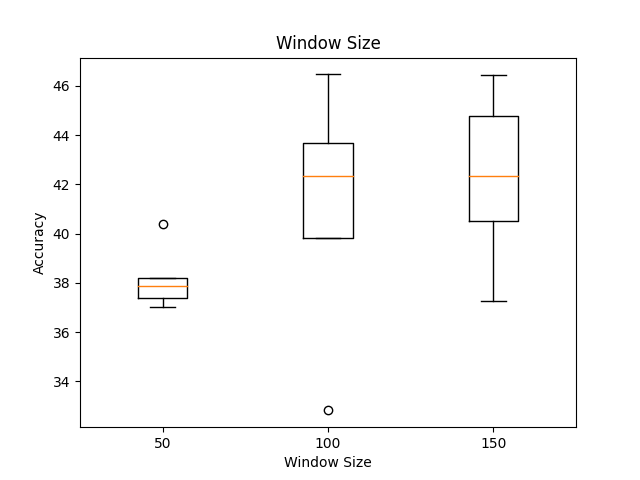

In [163]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Window Size')
ax1.set_ylabel('Accuracy')
ax1.set_title('Window Size')
ax1.boxplot([window_50_epochs_40, epochs_40, window_150_epochs_40], labels=['50', '100', '150'])
plt.show()

<IPython.core.display.Javascript object>


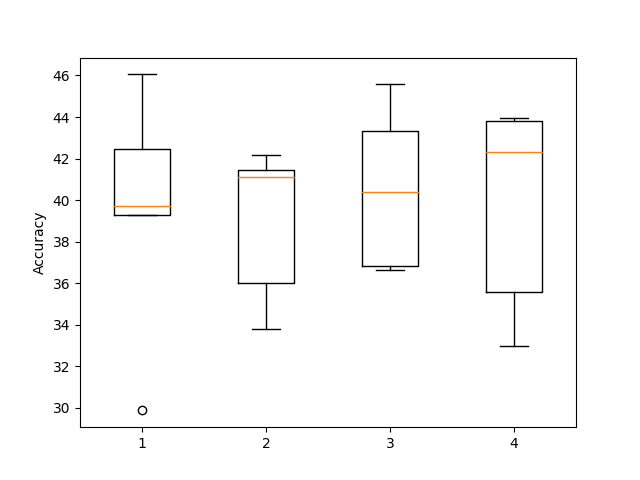

In [47]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.boxplot([epochs_10, layers_3_10, epochs_30, layers_3_30], labels=['1', '2', '3','4'])
plt.show()

<IPython.core.display.Javascript object>


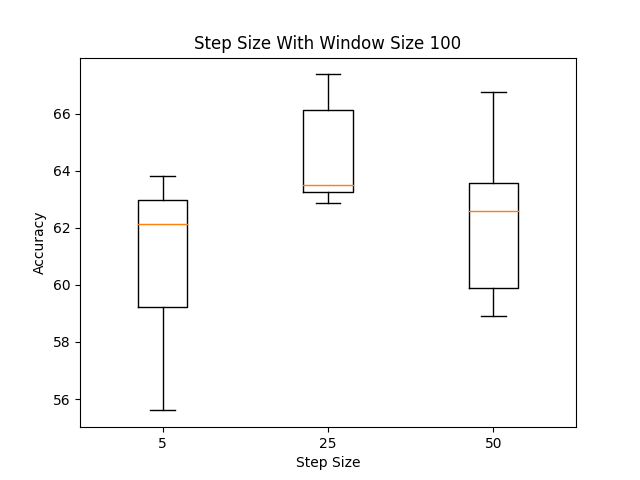

In [50]:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('Step Size')
ax1.set_ylabel('Accuracy')
ax1.set_title('Step Size With Window Size 100')
ax1.boxplot([epochs_40_full_data_batch_normalisation_grouped, window_100_steps_25, window_100_steps_50], labels=['5', '25', '50'])
plt.show()

<IPython.core.display.Javascript object>


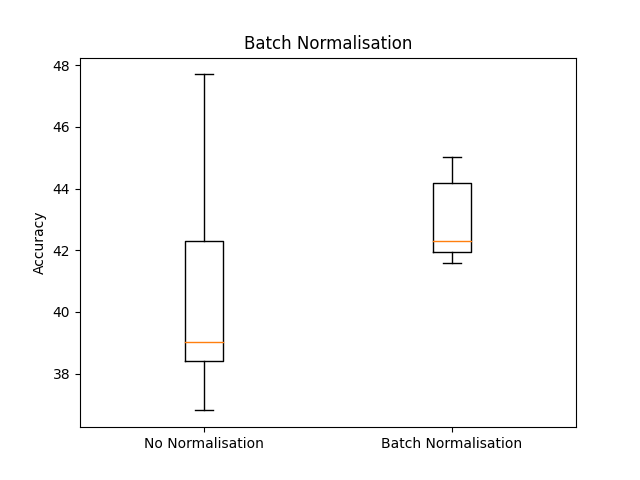

In [52]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Batch Normalisation')
ax1.boxplot([epochs_40_full_data, epochs_40_full_data_batch_normalisation], labels=['No Normalisation', 'Batch Normalisation'])
plt.show()

<IPython.core.display.Javascript object>


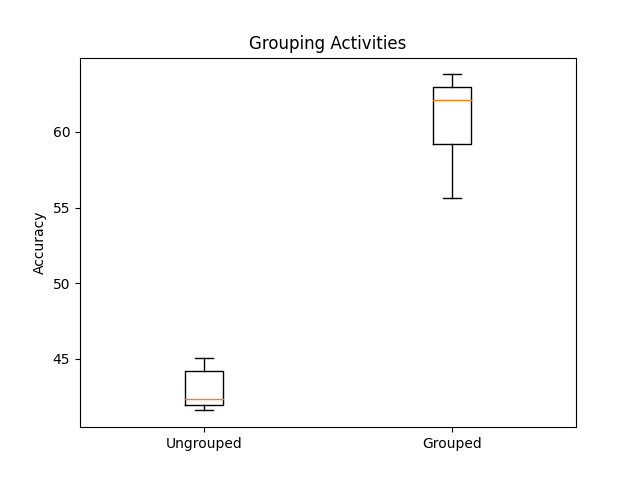

In [53]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Grouping Activities')
ax1.boxplot([epochs_40_full_data_batch_normalisation, epochs_40_full_data_batch_normalisation_grouped], labels=['Ungrouped', 'Grouped'])
plt.show()

<IPython.core.display.Javascript object>


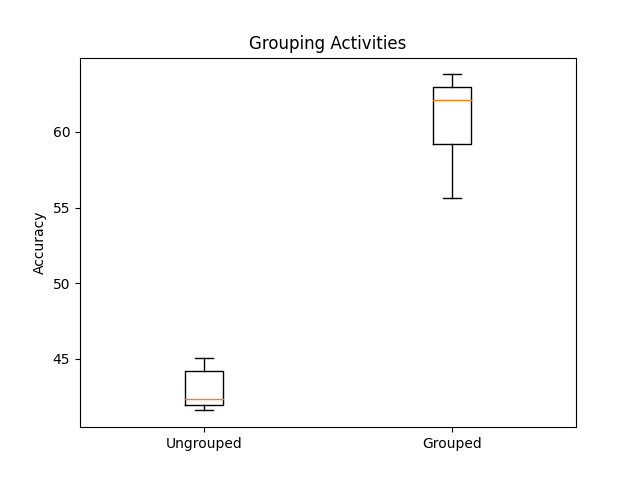

In [55]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Grouping Activities')
ax1.boxplot([epochs_40_full_data_batch_normalisation, epochs_40_full_data_batch_normalisation_grouped], labels=['Ungrouped', 'Grouped'])
plt.show()

<IPython.core.display.Javascript object>


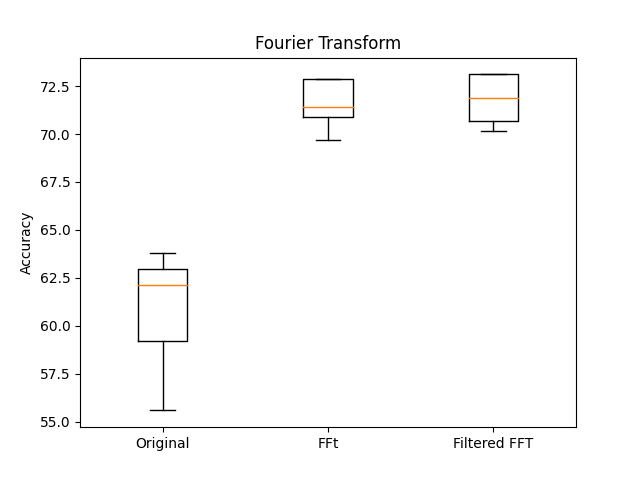

In [57]:
fig1, ax1 = plt.subplots()
ax1.set_ylabel('Accuracy')
ax1.set_title('Fourier Transform')
ax1.boxplot([epochs_40_full_data_batch_normalisation_grouped, fft_grouped, fft_filtering_01], labels=['Original', 'FFt', 'Filtered FFT'])
plt.show()